# Introduction

Today, internet and social media have become the fastest and easiest ways to get information. In this age, reviews, opinions, feedbacks, messages and recommendations have become significant source of information. Thanks to advancement in technologies, we are now able to extract meaningful information from such data using various Natural Language Processing (NLP) techniques. NLP , a branch of Artificial Intelligence (AI), makes use of computers and human natural language to output valuable information. NLP is commonly used in text classification task such as spam detection and sentiment analysis, text generation, language translations and document classification.

To understand how we can use TensorFlow2 to build SMS spam detection model. Particularly, we will build a binary classification model to detect whether a text message is spam or not (aka Ham). Moreover, we’ll learn how to implement Dense, Long Short Term Memory (LSTM)  deep learning models in TensorFlow2 Keras API

In [1]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
%matplotlib inline
# library from train test split
from sklearn.model_selection import train_test_split

#deep learning libraries from text pre-procesing
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import keras 
from keras.models import Sequential
from keras.layers import Embedding
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer


# Read raw dataset

In [2]:
# we also use seperater to bulit a proper dataframe
messages = pd.read_csv("SMSSpamCollection", sep ='\t', names= ["label","message"])
messages

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [3]:
messages.shape

(5572, 2)

In [4]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:7])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls
339   ham                             Sorry, I'll call later
357  spam  Congratulations ur awarded 500 of CD vouchers ...


looks like we have some duplicate messages.

In [7]:
messages.label.unique()

array(['ham', 'spam'], dtype=object)

In [8]:
messages.isnull().sum()

label      0
message    0
dtype: int64

# Visualization

C:\Users\vaibh\miniconda3\envs\Ai\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


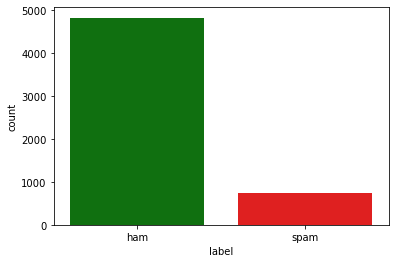

ham     4825
spam     747
Name: label, dtype: int64


In [9]:
sns.countplot(messages.label, palette = ["green", "red"])
plt.show()
print(messages.label.value_counts())

We have unbalanced labels, Later we have to balanced them.

In [10]:
# Get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']


In [11]:
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

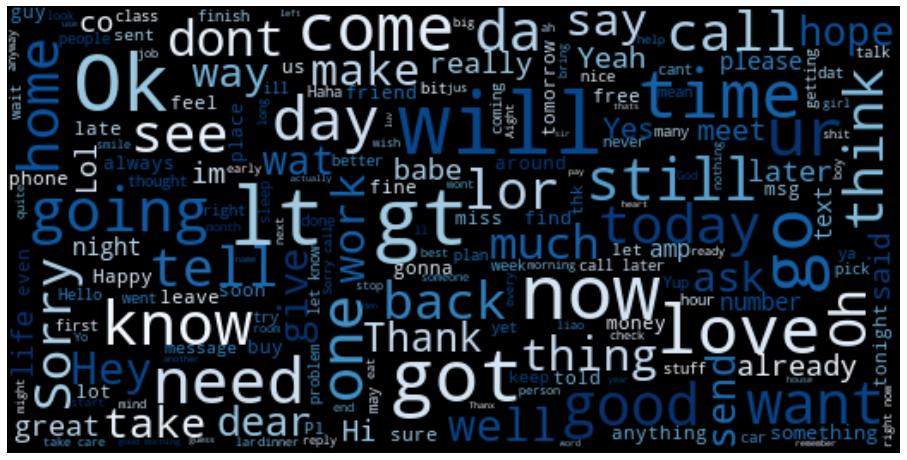

In [12]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

The ham message WordCloud below shows that "now", "work", "How", "love", "Ok" and "Sorry" are the most commonly appeared word in ham messages.

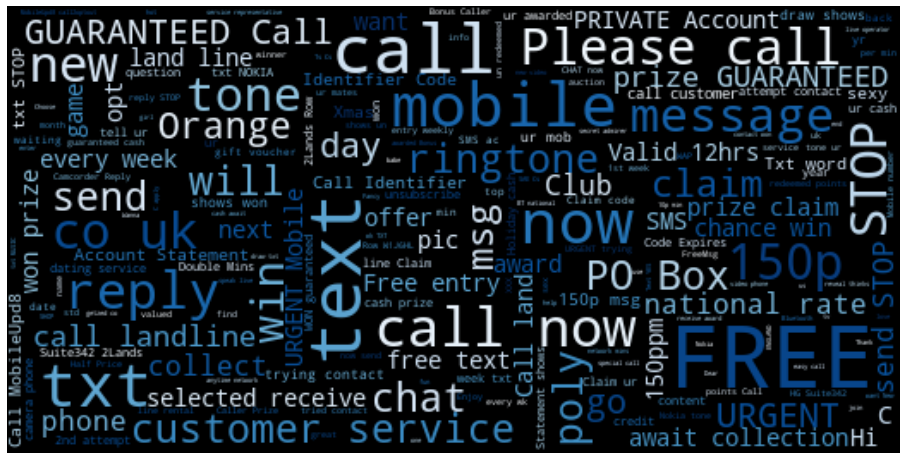

In [13]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

The spam message WordCloud below shows that "Free", "call", "text", "claim" and "reply" are most commonly appeared words in spam messages.

# Drop duplicates

In [14]:
df = messages.drop_duplicates()

In [15]:
df.shape

(5169, 2)

In [16]:
messages.shape

(5572, 2)

In [17]:
ham_msg = ham_msg.sample(spam_msg.shape[0])
print(ham_msg.shape)
print(spam_msg.shape)

(747, 2)
(747, 2)


In [18]:
# now we balanced our data

In [19]:
#append
data = ham_msg.append(spam_msg,ignore_index = True)
data.reset_index(inplace=True)

In [20]:
data

,index,label,message
0,0,ham,Yes! How is a pretty lady like you single?
1,1,ham,I forgot 2 ask ü all smth.. There's a card on ...
2,2,ham,Whens your radio show?
3,3,ham,Spoons it is then okay?
4,4,ham,Nokia phone is lovly..
...,...,...,...
1489,1489,spam,Want explicit SEX in 30 secs? Ring 02073162414...
1490,1490,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
1491,1491,spam,Had your contract mobile 11 Mnths? Latest Moto...
1492,1492,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [21]:
from sklearn.utils import shuffle
df = shuffle(data)

In [22]:
dt = df.copy()

In [23]:
dt.head()

,index,label,message
1121,1121,spam,Urgent Please call 09066612661 from landline. ...
421,421,ham,Im on gloucesterroad what are uup to later?
639,639,ham,I hope your alright babe? I worry that you mig...
881,881,spam,Hello. We need some posh birds and chaps to us...
272,272,ham,I'm now but have to wait till 2 for the bus to...


# Text Pre-processing

In [24]:
wn = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
def clean_text(txt):
    stripped = re.sub(r"<br />",' ',txt)
    text = re.sub(r'\d+', '', stripped)#remove numbers
    txt = "".join([c for c in text if c not in string.punctuation]) #remove punctuation
    tokens = nltk.word_tokenize(txt)# tokenizer
    text =  ([wn.lemmatize(word) for word in tokens if word not in stopwords]) #remove stopwords, #lemmatization
    return text 
dt["tok"] = dt["message"].apply(lambda x: clean_text(x.lower())) #lower


In [25]:
dt.head()

,index,label,message,tok
1121,1121,spam,Urgent Please call 09066612661 from landline. ...,"[urgent, please, call, landline, £, cash, luxu..."
421,421,ham,Im on gloucesterroad what are uup to later?,"[im, gloucesterroad, uup, later]"
639,639,ham,I hope your alright babe? I worry that you mig...,"[hope, alright, babe, worry, might, felt, bit,..."
881,881,spam,Hello. We need some posh birds and chaps to us...,"[hello, need, posh, bird, chap, user, trial, p..."
272,272,ham,I'm now but have to wait till 2 for the bus to...,"[im, wait, till, bus, pick]"


In [26]:
#save our pre-processed data
import pickle

pickle_out = open("sms.pickle","wb")
pickle.dump(dt,pickle_out)
pickle_out.close()

In [27]:
#load
import pickle
sms = pickle.load(open("sms.pickle","rb"))

In [28]:
sms

,index,label,message,tok
1121,1121,spam,Urgent Please call 09066612661 from landline. ...,"[urgent, please, call, landline, £, cash, luxu..."
421,421,ham,Im on gloucesterroad what are uup to later?,"[im, gloucesterroad, uup, later]"
639,639,ham,I hope your alright babe? I worry that you mig...,"[hope, alright, babe, worry, might, felt, bit,..."
881,881,spam,Hello. We need some posh birds and chaps to us...,"[hello, need, posh, bird, chap, user, trial, p..."
272,272,ham,I'm now but have to wait till 2 for the bus to...,"[im, wait, till, bus, pick]"
...,...,...,...,...
836,836,spam,22 days to kick off! For Euro2004 U will be ke...,"[day, kick, euro, u, kept, date, latest, news,..."
26,26,ham,Should I tell my friend not to come round til ...,"[tell, friend, come, round, til, like, ltgt, ish]"
476,476,ham,Well there's a pattern emerging of my friends ...,"[well, there, pattern, emerging, friend, telli..."
329,329,ham,S...from the training manual it show there is ...,"[sfrom, training, manual, show, tech, processi..."


In [29]:
X = sms["tok"]
Y = sms["label"]

# train test split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [31]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1195,)
(1195,)
(299,)
(299,)


In [32]:
y_train.value_counts()

ham     600
spam    595
Name: label, dtype: int64

In [33]:
y_test.value_counts()

spam    152
ham     147
Name: label, dtype: int64

In [34]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(y_train)
test_y = le.transform(y_test)

In [35]:
from keras.preprocessing.text import Tokenizer

max_feature = 500
tokenizer = Tokenizer(num_words = max_feature, char_level=False)

In [36]:
tokenizer.fit_on_texts(X_train)
X_train_features = np.array(tokenizer.texts_to_sequences(X_train))

X_test_features = np.array(tokenizer.texts_to_sequences(X_test))

C:\Users\vaibh\miniconda3\envs\Ai\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
C:\Users\vaibh\miniconda3\envs\Ai\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [37]:
X_test_features

array([list([230, 5, 57, 288, 161, 252, 488, 148, 32, 1, 150, 27]),
       list([119, 364, 295, 14, 492, 308, 39, 220]), list([258, 98, 20]),
       list([105, 147, 131, 43, 323, 4, 16, 6, 20, 40]),
       list([308, 28, 1, 1, 58, 235, 168]),
       list([366, 186, 16, 105, 349, 2, 186, 334, 186, 20]),
       list([52, 1, 93, 35, 466, 41, 28]), list([125, 52]),
       list([160, 71, 25, 131, 131, 33, 370, 51, 163, 131, 64]),
       list([2, 393, 103, 52, 295, 462, 329, 298]),
       list([248, 76, 11, 5, 3, 287, 79, 46, 7, 67, 394, 458, 60, 8, 64, 394, 88, 3, 379]),
       list([26, 8, 57, 3, 127, 214, 13, 248, 180, 34, 2, 1, 93, 42]),
       list([145, 2, 29, 466, 261, 24, 34, 171, 279, 1, 85, 44]),
       list([153, 139, 433, 28, 139, 2]),
       list([411, 100, 102, 201, 262, 61, 155, 370, 2, 25]),
       list([31, 1, 483, 26, 43, 120]), list([342, 442, 471]),
       list([244, 128, 100, 25]), list([455, 24, 1, 359, 4, 8]),
       list([68, 17, 60, 151, 27, 151, 6, 274, 86, 477, 9, 

In [38]:
#padding
from keras.preprocessing.sequence import pad_sequences

In [39]:
X_train_features = pad_sequences(X_train_features,padding="post",truncating="post", maxlen = 50 )
X_test_features = pad_sequences(X_test_features,padding="post",truncating="post", maxlen= 50)

In [40]:
X_train_features[0]

array([405,   9,  62, 405, 322,   5,   8, 163,   4, 323,   4,  16,   6,
       405, 289,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [41]:
X_train_features.shape

(1195, 50)

In [42]:
X_test_features[0]

array([230,   5,  57, 288, 161, 252, 488, 148,  32,   1, 150,  27,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [43]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Embedding,LSTM
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.layers import Dropout

In [50]:
model1 = Sequential()
model1.add(Embedding(input_dim=500,output_dim =16 ,input_length=50,name='embedding_layer'))
model1.add(LSTM(units=200, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(units=50, return_sequences=True))
model1.add(Dropout(0.2))

model1.add(Dense(1, activation='sigmoid'))

In [51]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 50, 16)            8000      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 200)           173600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 50)            50200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 50, 1)             51        
Total params: 231,851
Trainable params: 231,851
Non-trainable params: 0
________________________________________________

In [52]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [53]:
train_y

array([1, 0, 0, ..., 0, 0, 0])

In [54]:
history = model1.fit(X_train_features, train_y , validation_split=0.3, epochs=30, batch_size=500, shuffle=True, verbose = 1)

Epoch 1/30
1/1 [==============================] - 5s 5s/step - loss: 0.6932 - accuracy: 0.4803 - val_loss: 0.6936 - val_accuracy: 0.4178
Epoch 2/30
1/1 [==============================] - 1s 1s/step - loss: 0.6923 - accuracy: 0.5339 - val_loss: 0.6934 - val_accuracy: 0.4178
Epoch 3/30
1/1 [==============================] - 1s 1s/step - loss: 0.6913 - accuracy: 0.5325 - val_loss: 0.6932 - val_accuracy: 0.4178
Epoch 4/30
1/1 [==============================] - 1s 1s/step - loss: 0.6901 - accuracy: 0.5324 - val_loss: 0.6926 - val_accuracy: 0.4178
Epoch 5/30
1/1 [==============================] - 1s 1s/step - loss: 0.6883 - accuracy: 0.5322 - val_loss: 0.6917 - val_accuracy: 0.4178
Epoch 6/30
1/1 [==============================] - 1s 1s/step - loss: 0.6854 - accuracy: 0.5323 - val_loss: 0.6901 - val_accuracy: 0.4178
Epoch 7/30
1/1 [==============================] - 1s 1s/step - loss: 0.6808 - accuracy: 0.5323 - val_loss: 0.6874 - val_accuracy: 0.4178
Epoch 8/30
1/1 [=========================

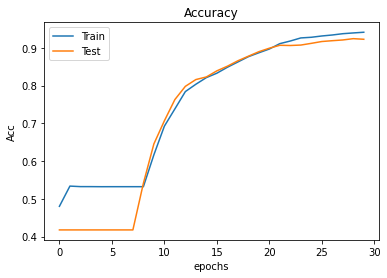

In [55]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

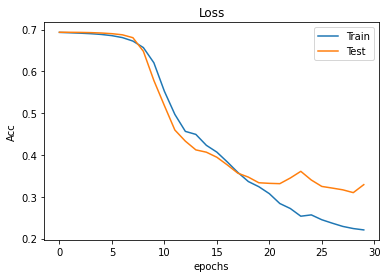

In [56]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [57]:
result = model1.evaluate(X_test_features, test_y)

10/10 [==============================] - 1s 72ms/step - loss: 0.2690 - accuracy: 0.9337


In [58]:
pd.options.display.max_colwidth=100
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...


In [59]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

In [61]:
# Defining prediction function
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =50,
                      padding = "post",
                      truncating="post")
    return (model1.predict(padded))
predict_spam(predict_msg)

array([[[0.50563204],
        [0.5093872 ],
        [0.5137089 ],
        [0.51674056],
        [0.5155632 ],
        [0.511467  ],
        [0.50673664],
        [0.49576727],
        [0.47747645],
        [0.44445938],
        [0.3936585 ],
        [0.32628664],
        [0.2515592 ],
        [0.18453701],
        [0.13576922],
        [0.10544083],
        [0.0882137 ],
        [0.07890724],
        [0.07410581],
        [0.0718049 ],
        [0.07085997],
        [0.07062203],
        [0.0707271 ],
        [0.07097548],
        [0.07126207],
        [0.07153553],
        [0.07177414],
        [0.07197193],
        [0.07213052],
        [0.07225481],
        [0.07235067],
        [0.07242373],
        [0.07247893],
        [0.07252035],
        [0.07255128],
        [0.0725743 ],
        [0.0725914 ],
        [0.07260406],
        [0.0726135 ],
        [0.07262047],
        [0.07262565],
        [0.0726295 ],
        [0.0726324 ],
        [0.07263459],
        [0.07263621],
        [0

In [62]:
predict_msg = ["You are awarded a Nikon Digital Camera. Call now",
               "Call me",
          "What's up?"]
predict_spam(predict_msg)

array([[[0.50984955],
        [0.52952576],
        [0.5622835 ],
        [0.61544055],
        [0.6799564 ],
        [0.7524828 ],
        [0.8257537 ],
        [0.88944656],
        [0.93563867],
        [0.96382093],
        [0.97910666],
        [0.9871018 ],
        [0.9914534 ],
        [0.9940211 ],
        [0.99562895],
        [0.9966271 ],
        [0.9972114 ],
        [0.997531  ],
        [0.9976968 ],
        [0.99778086],
        [0.9978235 ],
        [0.99784565],
        [0.99785787],
        [0.9978649 ],
        [0.99786925],
        [0.997872  ],
        [0.9978739 ],
        [0.9978752 ],
        [0.99787617],
        [0.99787676],
        [0.99787724],
        [0.9978777 ],
        [0.99787796],
        [0.9978782 ],
        [0.9978783 ],
        [0.99787843],
        [0.99787855],
        [0.9978787 ],
        [0.9978787 ],
        [0.9978788 ],
        [0.9978788 ],
        [0.9978788 ],
        [0.9978789 ],
        [0.9978789 ],
        [0.9978789 ],
        [0